In [20]:
import numpy as np
import random
import os
import networkx as nx
import matplotlib.pyplot as plt
from scipy import sparse

from setup_networks import network_from_txt, network_indices, Network, network_from_edges_and_nodes
from currents import * 
from adaptation import adaptation_ode, ss_solve
from measures import steady_state_dissipation
from tqdm import tqdm

In [4]:
N_kappas = 5
N_rhos = 5
N_sinks = 50
N_replicates=10

kappas = np.logspace(-3, 0, N_kappas)
rhos = np.logspace(0, 2, N_rhos)

gamma = 0.5
beta = 1.0 / (1 + gamma)

In [95]:
netw = network_from_txt("../lattices/paper_edges.txt", "../lattices/paper_nodes.txt")
inds = network_indices(netw)
i = inds['left']

In [96]:
energies = np.zeros((N_kappas, N_rhos))
for k in tqdm(range(N_kappas)):
    for p in range(N_rhos):
        kappa = kappas[k]
        rho = rhos[p]
        
        E = 0
        for _ in range(N_replicates):
            K0 = -np.log10(np.random.rand(netw.N_e))
            sink_nodes = np.random.randint(0, netw.N_v, size=N_sinks)
            currents = lambda K, netw: static_currents(K, netw, source_index=i, sink_nodes=sink_nodes)
            K, converged = ss_solve(lambda K, t: adaptation_ode(K, t, netw, currents, kappa, beta, rho), K0, Δt=1.0)
            if not converged:
                print(f"Did not converge at k={kappa}, p={rho}")
                
                
            I = np.sqrt(currents(K, netw))
            R = netw.lengths/K
            E += np.mean(I*R)
            #E += steady_state_dissipation(K, netw, source_index=i)
        
        energies[k, p] = E/N_replicates
# np.save(f'energies_a1_b1_source{i}.txt')
        

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [13:36<00:00, 163.23s/it]


Text(0.5, 1.0, 'Source: Left')

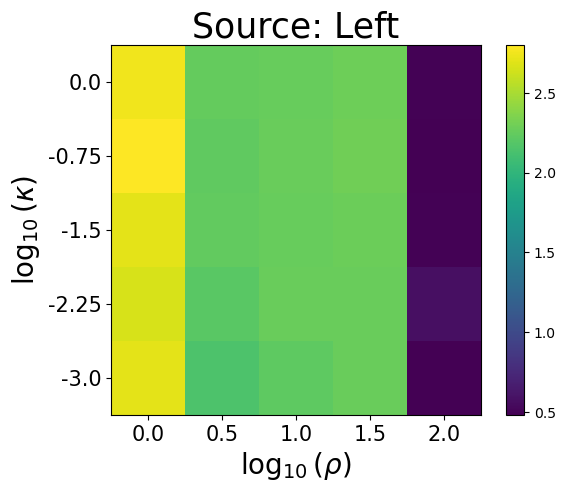

In [97]:
plt.imshow(energies, origin='lower')
plt.xlabel(r'$\log_{10}(\rho)$', fontsize=20);
plt.ylabel(r'$\log_{10}(\kappa)$', fontsize=20);
plt.xticks(ticks=np.arange(N_rhos), labels=np.log10(rhos), fontsize=15);
plt.yticks(ticks=np.arange(N_kappas), labels=np.log10(kappas), fontsize=15);
plt.colorbar();
plt.title('Source: Left', fontsize=22)

In [98]:
energies

array([[2.70019265, 2.15321448, 2.22491369, 2.26746096, 0.48473547],
       [2.66164955, 2.21013684, 2.27056925, 2.27263816, 0.58216507],
       [2.70573063, 2.2452602 , 2.26403887, 2.2750082 , 0.49330181],
       [2.79893051, 2.23342505, 2.27394914, 2.29265325, 0.48381813],
       [2.74682092, 2.24967048, 2.26028476, 2.29181618, 0.49536842]])

# Vary aspect ratio

In [5]:
def make_ellipse_netw(netw, a, b):
    center_ind = network_indices(netw)['center']

    max_dist = np.max(np.linalg.norm(netw.pos - netw.pos[center_ind], axis=1))
    a = a/max_dist
    b = b/max_dist
    
    ellipse_dist_fn = lambda x: (x[:, 0] - x[center_ind,0])**2/a**2 + (x[:, 1]-x[center_ind,1])**2/b**2
    ellipse_dists = ellipse_dist_fn(netw.pos)
    
    inside_ellipse_ids = np.where(ellipse_dists <= 1.)[0]
    new_pos = netw.pos[inside_ellipse_ids]
    new_ids = np.arange(len(new_pos))
    
    def get_ellipse_edges(edges, ellipse_ids):
        ellipse_edges = []
        for e in edges:
            is_in_ellipse = np.any(e[0]==ellipse_ids) and np.any(e[1]==ellipse_ids)
            if is_in_ellipse:
                #find the new ids of the nodes to form edges
                e1 = new_ids[np.where(e[0]==inside_ellipse_ids)[0][0]]
                e2 = new_ids[np.where(e[1]==inside_ellipse_ids)[0][0]]
                ellipse_edges += [[e1, e2]]        
        return np.array(ellipse_edges)

    new_edges = get_ellipse_edges(netw.edgelist, inside_ellipse_ids)
    
    return network_from_edges_and_nodes(new_edges, new_pos)

In [21]:
# define aspect ratio of ellipse by varying a, b
a = 1.
b = 0.6
netw = network_from_txt("../lattices/paper_edges.txt", "../lattices/paper_nodes.txt")
ellipse_netw = make_ellipse_netw(netw, a, b)
inds_ellipse = network_indices(ellipse_netw)
i_ellipse = inds_ellipse['left']

(0.5937104580000002, 2.946577722, -0.7307021658749999, 0.6605588591250005)

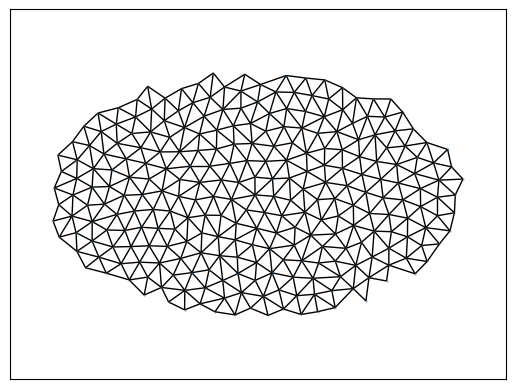

In [22]:
G = nx.Graph()
node_pos = ellipse_netw.pos
nodes = np.arange(len(node_pos))
node_dict = {}
for n in nodes:
    node_dict[n] = node_pos[n]

edges = ellipse_netw.edgelist
G.add_nodes_from(nodes)
G.add_edges_from(edges)


nx.draw_networkx(G, pos=node_dict, width=1., with_labels=False, node_size=0.1)
plt.axis('equal')


In [24]:
N_kappas = 2
N_rhos = 2
N_sinks = 50
N_replicates=1

kappas = np.logspace(-3, 0, N_kappas)
rhos = np.logspace(0, 2, N_rhos)

gamma = 0.5
beta = 1.0 / (1 + gamma)


energies = np.zeros((N_kappas, N_rhos))
for k in tqdm(range(N_kappas)):
    for p in range(N_rhos):
        kappa = kappas[k]
        rho = rhos[p]
        
        E = 0
        for _ in range(N_replicates):
            K0 = -np.log10(np.random.rand(ellipse_netw.N_e))
            sink_nodes = np.random.randint(0, ellipse_netw.N_v, size=N_sinks)
            currents = lambda K, netw: static_currents(K, ellipse_netw, source_index=i_ellipse, sink_nodes=sink_nodes)
            K, converged = ss_solve(lambda K, t: adaptation_ode(K, t, ellipse_netw, currents, kappa, beta, rho), K0, Δt=1.0)
            if not converged:
                print(f"Did not converge at k={kappa}, p={rho}")
                
                
            I = np.sqrt(currents(K, ellipse_netw))
            R = ellipse_netw.lengths/K
            E += np.mean(I*R)
        
        energies[k, p] = E/N_replicates
        
# np.save(f'energies_a{a}_b{b}_source{i_ellipse}.txt')

100%|█████████████████████████████████████████████| 2/2 [00:17<00:00,  8.80s/it]


NameError: name 'i' is not defined

Text(0.5, 1.0, 'Source: Left, Aspect ratio: 1.0/0.6')

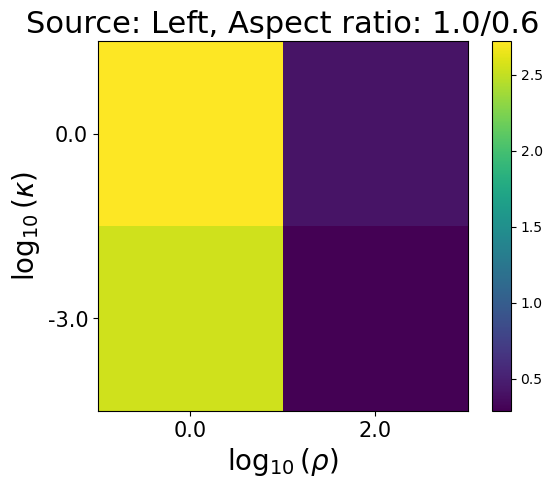

In [25]:
plt.imshow(energies, origin='lower')
plt.xlabel(r'$\log_{10}(\rho)$', fontsize=20);
plt.ylabel(r'$\log_{10}(\kappa)$', fontsize=20);
plt.xticks(ticks=np.arange(N_rhos), labels=np.log10(rhos), fontsize=15);
plt.yticks(ticks=np.arange(N_kappas), labels=np.log10(kappas), fontsize=15);
plt.colorbar();
plt.title(f'Source: Left, Aspect ratio: {a}/{b}', fontsize=22)

In [26]:
energies

array([[2.54641419, 0.28876374],
       [2.72040591, 0.42130058]])